# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from sklearn.dummy import DummyRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from yellowbrick.model_selection import RFECV
from yellowbrick.regressor import ManualAlphaSelection
from yellowbrick.regressor import AlphaSelection
from yellowbrick.model_selection import LearningCurve

sns.set()

# Loading the dataset

In [2]:
current_dir = os.getcwd()
train_file_path = os.path.join(current_dir, 'CMAPSSData/train_FD001.txt')
test_file_path = os.path.join(current_dir, 'CMAPSSData/test_FD001.txt')
RUL_file_path = os.path.join(current_dir, 'CMAPSSData/RUL_FD001.txt')

In [3]:
column_names = ['unit_no', 'cycles', 'setting_1', 'setting_2', 'setting_3']
sensor_names = ['sensor_{}'.format(i) for i in range(1, 22)]

features_names = column_names + sensor_names

In [4]:
train = pd.read_csv(train_file_path, sep='\s+', header = None, names = features_names)
test = pd.read_csv(test_file_path, sep='\s+', header = None, names = features_names)
y_test = pd.read_csv(RUL_file_path, sep='\s+', header=None, names = ['RUL'])

In [5]:
sensors_to_drop = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
labels_to_drop = column_names + sensors_to_drop

# Utility functions

In [6]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_pred)
    print('RMSE : {} and R2 : {}'.format(rmse, variance))
    
def evaluate_train_test(model, X_train, y_train, X_test, y_test):
    print('Training_performance')
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    evaluate_model(y_train, y_pred_train)
    print('\nTesting_performance')
    y_pred_test = model.predict(X_test)
    evaluate_model(y_test, y_pred_test)

In [7]:
def plot_learning_curves(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train_errors, test_errors = [], []
    for m in range(500, len(X_train), 500):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_test_pred = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        test_errors.append(mean_squared_error(y_test, y_test_pred))
    plt.plot(-np.sqrt(train_errors), label="train")
    plt.plot(-np.sqrt(test_errors), label="test")
    plt.xlabel("Training set size")
    plt.ylabel("RMSE")
    plt.legend(loc="upper right", fontsize=14)
    plt.title("Learning curves")

In [8]:
def append_rul(df):
    df_by_unit_no = df.groupby('unit_no')
    max_nb_cycles = pd.DataFrame(df_by_unit_no['cycles'].max()).rename(columns={'cycles': 'max_cycles'})
    output = df.merge(max_nb_cycles, how = 'inner', on = 'unit_no')
    output['RUL'] = output['max_cycles'] - output['cycles']
    output = output.drop(columns=['max_cycles'])
    return output

train = append_rul(train)

# Pipeline

In [9]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Train/test sets

In [10]:
X_train = train.drop(labels_to_drop, axis=1)
y_train = X_train.pop('RUL')
y_train_clipped = y_train.clip(upper=125).values.reshape(-1)
y_train = y_train.values.reshape(-1)

X_test = test.groupby('unit_no').last().reset_index().drop(labels_to_drop, axis=1).values
y_test = y_test.values.reshape(-1)

In [13]:
X_train.values

array([[ 641.82  , 1589.7   , 1400.6   , ...,  392.    ,   39.06  ,
          23.419 ],
       [ 642.15  , 1591.82  , 1403.14  , ...,  392.    ,   39.    ,
          23.4236],
       [ 642.35  , 1587.99  , 1404.2   , ...,  390.    ,   38.95  ,
          23.3442],
       ...,
       [ 643.42  , 1602.46  , 1428.18  , ...,  398.    ,   38.44  ,
          22.9333],
       [ 643.23  , 1605.26  , 1426.53  , ...,  395.    ,   38.29  ,
          23.064 ],
       [ 643.85  , 1600.38  , 1432.14  , ...,  396.    ,   38.37  ,
          23.0522]])

In [12]:
X_train_scaled = pipeline.fit_transform(X_train)
X_train_scaled

array([[-1.72172539, -0.13425518, -0.92593596, ..., -0.78170979,
         1.34849274,  1.19442705],
       [-1.06177971,  0.21152849, -0.64372587, ..., -0.78170979,
         1.01652793,  1.23692196],
       [-0.66181262, -0.41316559, -0.52595315, ..., -2.07309423,
         0.73989059,  0.50342281],
       ...,
       [ 1.47801126,  1.94697106,  2.13837684, ...,  3.09244354,
        -2.08181033, -3.29248147],
       [ 1.09804254,  2.40366648,  1.95505138, ...,  1.15536688,
        -2.91172236, -2.08507166],
       [ 2.33794049,  1.60771161,  2.57835793, ...,  1.8010591 ,
        -2.46910261, -2.19408035]])

In [19]:
X_train

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [20]:
pd.DataFrame(X_train_scaled, columns=X_train.columns)

,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-1.721725,-0.134255,-0.925936,1.121141,-0.516338,-0.862813,-0.266467,0.334262,-1.058890,-0.269071,-0.603816,-0.781710,1.348493,1.194427
1,-1.061780,0.211528,-0.643726,0.431930,-0.798093,-0.958818,-0.191583,1.174899,-0.363646,-0.642845,-0.275852,-0.781710,1.016528,1.236922
2,-0.661813,-0.413166,-0.525953,1.008155,-0.234584,-0.557139,-1.015303,1.364721,-0.919841,-0.551629,-0.649144,-2.073094,0.739891,0.503423
3,-0.661813,-1.261314,-0.784831,1.222827,0.188048,-0.713826,-1.539489,1.961302,-0.224597,-0.520176,-1.971665,-0.781710,0.352598,0.777792
4,-0.621816,-1.251528,-0.301518,0.714393,-0.516338,-0.457059,-0.977861,1.052871,-0.780793,-0.521748,-0.339845,-0.136018,0.463253,1.059552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,1.618000,1.216258,2.188375,-2.189329,1.315066,0.012547,1.980044,-2.607969,2.278282,-0.322542,1.425294,2.446751,-1.805173,-2.921113
20627,1.717992,2.279706,2.738351,-2.833345,1.878576,-0.006020,1.867718,-2.350355,1.722087,-0.380207,1.913240,1.155367,-2.856395,-1.203764
20628,1.478011,1.946971,2.138377,-2.742957,2.019453,0.029755,2.054927,-1.902919,2.000184,-0.141684,3.265092,3.092444,-2.081810,-3.292481
20629,1.098043,2.403666,1.955051,-3.036719,2.160330,0.383884,3.178182,-2.363913,1.861136,-0.233948,2.579834,1.155367,-2.911722,-2.085072


# Baseline (dummy regressor)

In [11]:
dummy = DummyRegressor(strategy='mean')

evaluate_train_test(dummy, X_train, y_train, X_test, y_test)

Training_performance
RMSE : 68.87932080043385 and R2 : 0.0

Testing_performance
RMSE : 52.62485752612688 and R2 : -0.6036970189556603


In [12]:
evaluate_train_test(dummy, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 41.67268886461814 and R2 : 0.0

Testing_performance
RMSE : 43.06703554245684 and R2 : -0.07406462561807858


# RandomForest Regressor

## No clipping

In [21]:
rf = RandomForestRegressor()

evaluate_train_test(rf, X_train, y_train, X_test, y_test)

Training_performance
RMSE : 15.586199580935794 and R2 : 0.9487961337933104

Testing_performance
RMSE : 33.868780447485854 and R2 : 0.3357377482353039


### Residuals

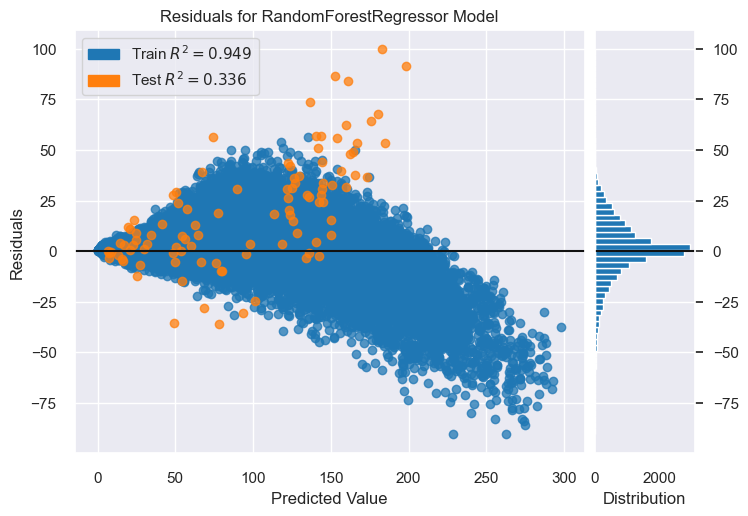

In [22]:
visualizer_rf = ResidualsPlot(rf, train_color='tab:blue', test_color='tab:orange')
visualizer_rf.fit(X_train, y_train)
visualizer_rf.score(X_test, y_test)

visualizer_rf.show();

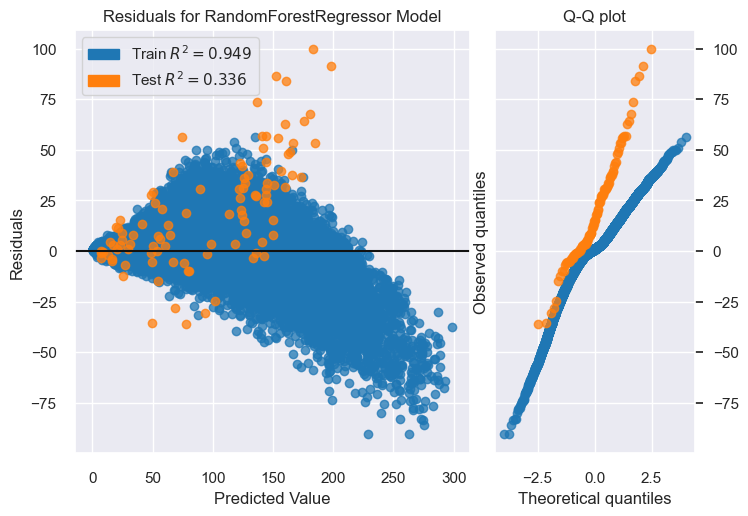

In [23]:
visualizer_rf = ResidualsPlot(rf, train_color='tab:blue', test_color='tab:orange', qqplot=True, hist=False)
visualizer_rf.fit(X_train, y_train)
visualizer_rf.score(X_test, y_test)

visualizer_rf.show();

### Prediction Error

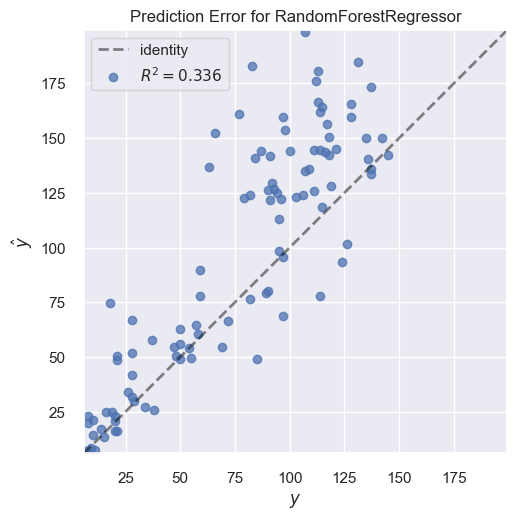

In [31]:
from yellowbrick.regressor.prediction_error import prediction_error

visualizer = prediction_error(rf, X_train, y_train, X_test, y_test, bestfit=False);

### Learning Curve

In [150]:
visualizer_rf = LearningCurve(rf, scoring='neg_root_mean_squared_error',
                              train_color='tab:blue', 
                              test_color='tab:orange')
visualizer_rf.fit(X_train, y_train)
visualizer_rf.score(X_test, y_test)

# Call finalize to draw the final yellowbrick-specific elements
visualizer_rf.finalize()

# Get access to the axes object and modify labels
visualizer_rf.ax.set_title("Learning Curve for RandomForestRegressor (no clipping)")
visualizer_rf.ax.set_ylabel("neg RMSE")

plt.savefig('model_figs/rf/rf_no_clip_learning_curve.png')

## Clipping

In [39]:
rf = RandomForestRegressor()

evaluate_train_test(rf, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 6.829945201931934 and R2 : 0.973138430072555

Testing_performance
RMSE : 18.153543786269392 and R2 : 0.8091626883697529


### Residuals

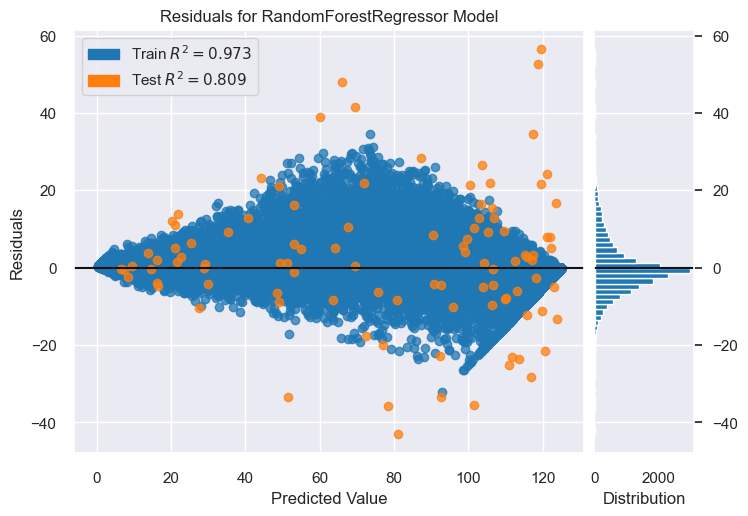

In [40]:
visualizer_rf = ResidualsPlot(rf, train_color='tab:blue', test_color='tab:orange')
visualizer_rf.fit(X_train, y_train_clipped)
visualizer_rf.score(X_test, y_test)

visualizer_rf.show();

### Prediction Error

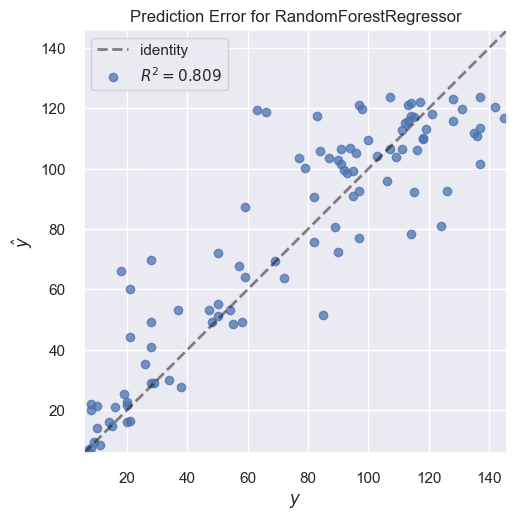

In [41]:
visualizer_rf = PredictionError(rf, bestfit=False)
visualizer_rf.fit(X_train, y_train_clipped)
visualizer_rf.score(X_test, y_test)

visualizer_rf.show();

## Hyperparameter tuning

In [43]:
params_dict = {
    "n_estimators": [50, 100, 250, 400, 550],
    "max_depth": [None, 5, 10, 20],
    "min_samples_leaf": [1, 0.01, 0.05],
    "max_features": ["auto", "sqrt"]
}

random_search = RandomizedSearchCV(rf, params_dict, cv=5, scoring="neg_mean_squared_error", n_iter=20)
random_search.fit(X_train, y_train_clipped)
random_search.best_params_

{'n_estimators': 550,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10}

In [44]:
rf_tuned = random_search.best_estimator_

evaluate_train_test(rf_tuned, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 15.74424984805099 and R2 : 0.8572615754480223

Testing_performance
RMSE : 17.933080242298768 and R2 : 0.8137697444110855


### Learning curve

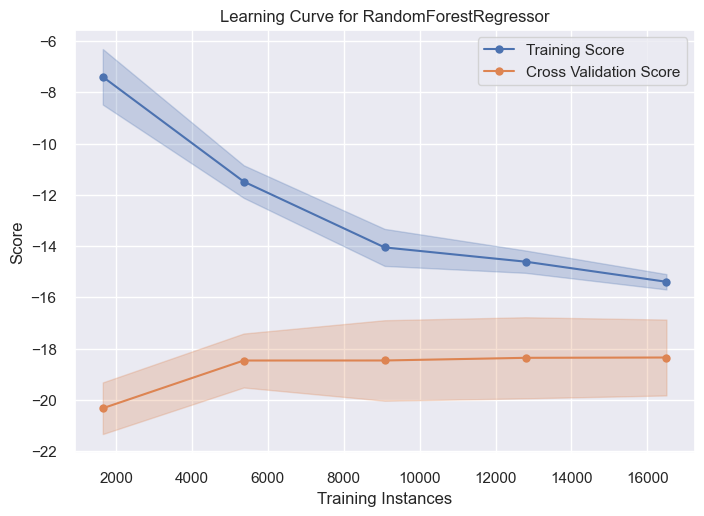

In [46]:
visualizer_rf_tuned = LearningCurve(rf_tuned, scoring='neg_root_mean_squared_error',
                              train_color='tab:blue', 
                              test_color='tab:orange')
visualizer_rf_tuned.fit(X_train, y_train_clipped)
visualizer_rf_tuned.score(X_test, y_test)

visualizer_rf_tuned.show();

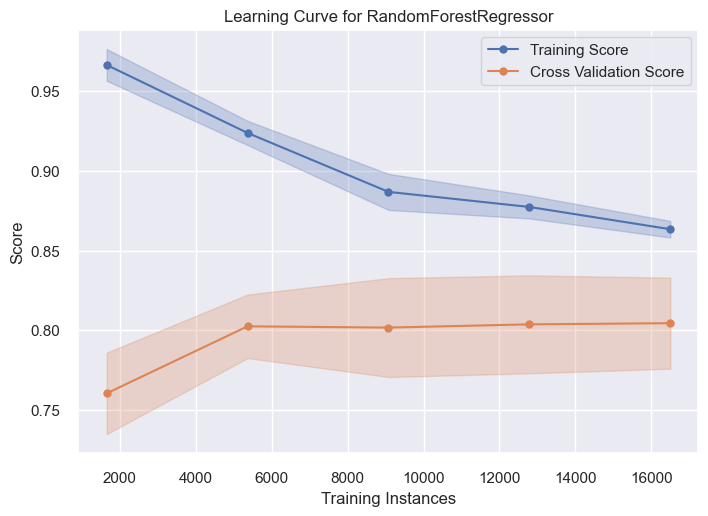

In [145]:
visualizer_rf_tuned = LearningCurve(rf_tuned, scoring='r2',
                              train_color='tab:blue', 
                              test_color='tab:orange')
visualizer_rf_tuned.fit(X_train, y_train_clipped)
visualizer_rf_tuned.score(X_test, y_test)

visualizer_rf_tuned.show();

In [147]:
plot_learning_curves(rf_tuned, X_train, y_train)

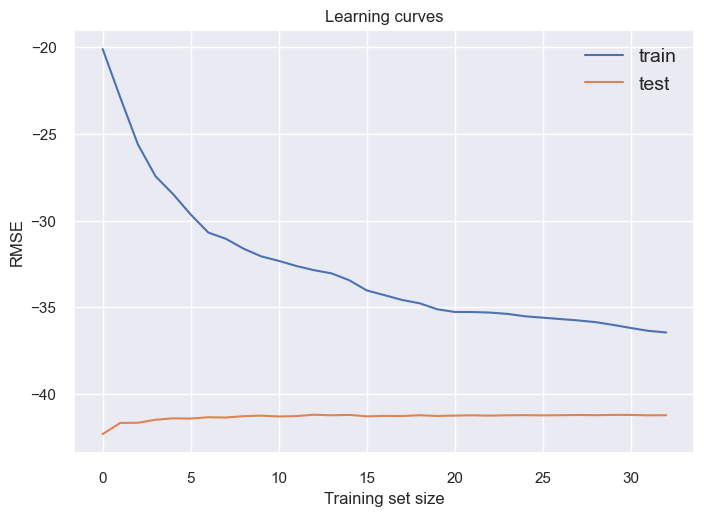

In [148]:
plt.show()

# K Means

In [64]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter tuning

In [78]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

kmeans = Pipeline([
    ("pca", PCA(n_components=2, random_state=42)),
    ('model', KMeans())
])

params_dict={
    'model__n_clusters': np.arange(1, 11, 10), 
    'model__max_iter': [100, 1000, 2000],
    'model__n_init': [10, 20]
    
}

grid_kmeans = GridSearchCV(kmeans, 
                           params_dict, 
                           scoring='neg_mean_squared_error',
                           cv=5)
grid_kmeans.fit(X_train_scaled, y_train_clipped)

grid_kmeans.best_params_

{'model__max_iter': 100, 'model__n_clusters': 1, 'model__n_init': 10}

In [79]:
evaluate_train_test(grid_kmeans, X_train_scaled, y_train_clipped, X_test_scaled, y_test)

Training_performance
RMSE : 96.31167067895736 and R2 : -4.341396110641242

Testing_performance
RMSE : 86.19825984322422 and R2 : -3.3026641965322696


In [ ]:
np.arange(1, 11, 1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [90]:
kmeans.fit_predict(X_train_scaled, y_train_clipped)
kmeans.predict(X_test_scaled)

array([0, 6, 1, 1, 6, 6, 0, 6, 6, 6, 1, 5, 6, 6, 0, 0, 5, 1, 6, 3, 0, 0,
       0, 5, 0, 4, 6, 6, 0, 6, 7, 5, 6, 3, 3, 3, 1, 5, 4, 3, 1, 3, 1, 6,
       1, 5, 6, 6, 3, 0, 6, 5, 7, 4, 0, 3, 6, 1, 4, 6, 1, 5, 1, 1, 4, 2,
       0, 7, 6, 6, 0, 6, 0, 6, 0, 7, 1, 4, 6, 6, 3, 3, 0, 1, 6, 6, 0, 6,
       6, 7, 3, 3, 1, 1, 0, 4, 5, 6, 4, 2], dtype=int32)

In [87]:
kmeans[1].labels_

array([2, 0, 2, ..., 5, 5, 5], dtype=int32)

In [91]:
kmeans[1].cluster_centers_

array([[-1.72597547, -0.02258807],
       [ 2.42944604, -0.94927384],
       [ 5.88345889,  5.02844509],
       [ 5.92054757, -1.58631194],
       [-3.76732266,  0.40212582],
       [ 0.72432732,  1.7023568 ],
       [ 0.14611813, -0.78401238],
       [ 3.9910526 ,  1.86465535]])

# K Nearest Neighbors

## No clipping

In [166]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

evaluate_train_test(knn, X_train, y_train, X_test, y_test)

Training_performance
RMSE : 38.98994833237376 and R2 : 0.6795741040417037

Testing_performance
RMSE : 36.30755844173497 and R2 : 0.2366309534894816


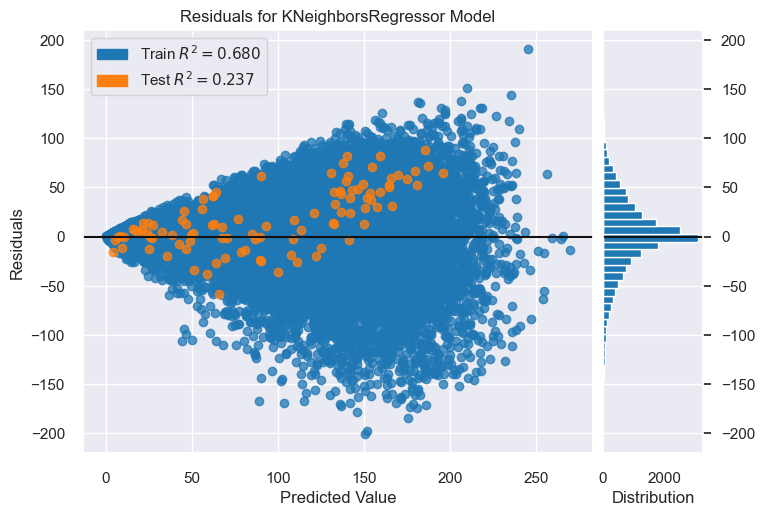

In [167]:
visualizer_knn = ResidualsPlot(knn, train_color='tab:blue', test_color='tab:orange')
visualizer_knn.fit(X_train, y_train)
visualizer_knn.score(X_test, y_test)

visualizer_knn.show();

### Prediction Error

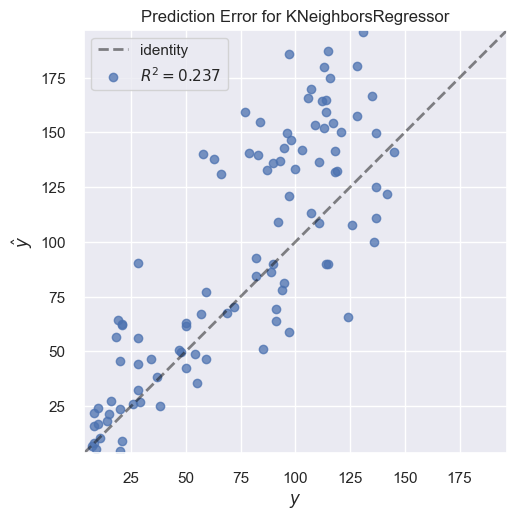

In [168]:
visualizer = PredictionError(knn, bestfit=False)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();

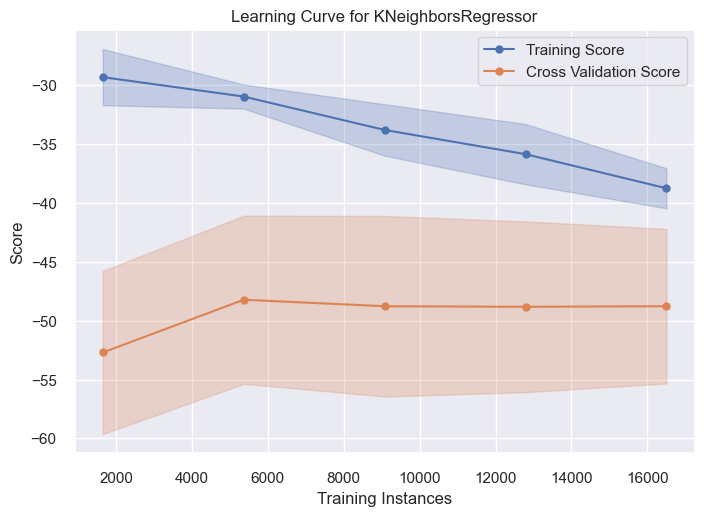

In [169]:
visualizer = LearningCurve(knn, scoring='neg_root_mean_squared_error',
                              train_color='tab:blue', 
                              test_color='tab:orange')
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

visualizer.show();

## Clipping

In [101]:
evaluate_train_test(knn, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 18.12939954108852 and R2 : 0.8107378395480288

Testing_performance
RMSE : 22.465137435591174 and R2 : 0.7077472439146534


In [122]:
params_dict = {
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'n_neighbors': [5, 10, 20, 50, 100],
}

grid_knn = GridSearchCV(knn, params_dict, cv=5, scoring='neg_mean_squared_error')

grid_knn.fit(X_train, y_train_clipped)

grid_knn.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 50}

In [123]:
knn_tuned = grid_knn.best_estimator_

evaluate_train_test(knn_tuned, X_train, y_train_clipped, X_test, y_test)

Training_performance
RMSE : 20.409300397308478 and R2 : 0.7601425629213685

Testing_performance
RMSE : 20.20874177181746 and R2 : 0.7635066110376835


In [119]:
knn_tuned.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 50,
 'p': 2,
 'weights': 'uniform'}

In [124]:
best_knn = KNeighborsRegressor()

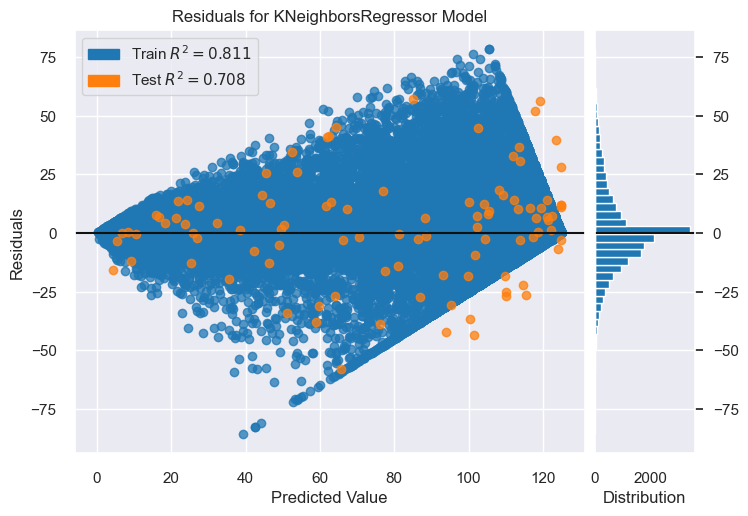

In [170]:
visualizer_knn = ResidualsPlot(best_knn, train_color='tab:blue', test_color='tab:orange')
visualizer_knn.fit(X_train, y_train_clipped)
visualizer_knn.score(X_test, y_test)

visualizer_knn.show();

### Prediction Error

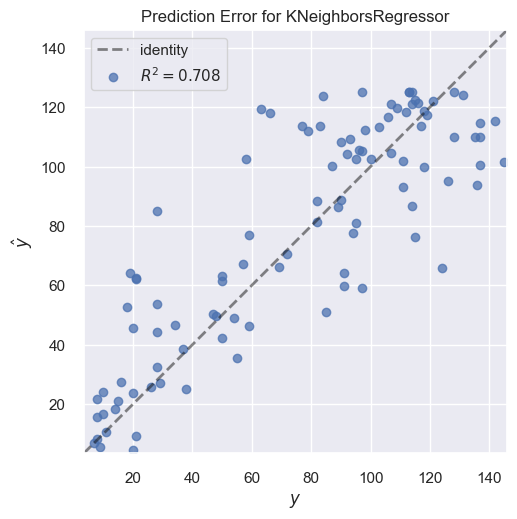

In [171]:
visualizer_knn = PredictionError(best_knn, bestfit=False)
visualizer_knn.fit(X_train, y_train_clipped)
visualizer_knn.score(X_test, y_test)
visualizer_knn.show();

### Learning Curve

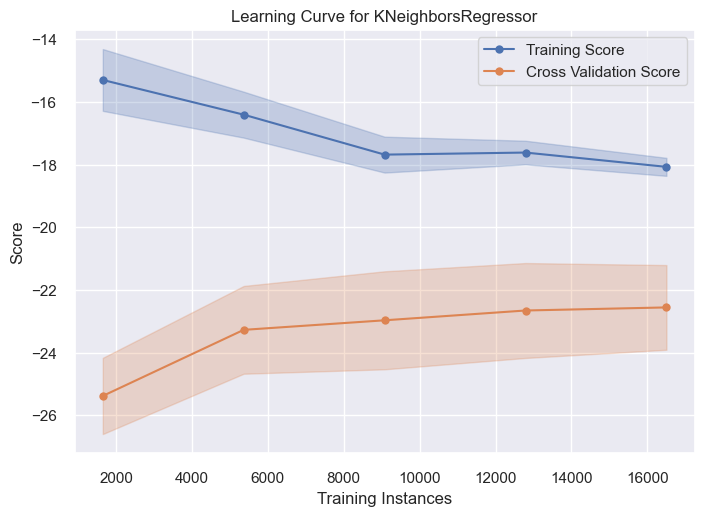

In [131]:
visualizer_knn = LearningCurve(best_knn, scoring='neg_root_mean_squared_error', cv=5)
visualizer_knn.fit(X_train, y_train_clipped)
visualizer_knn.score(X_test, y_test)
visualizer_knn.show();

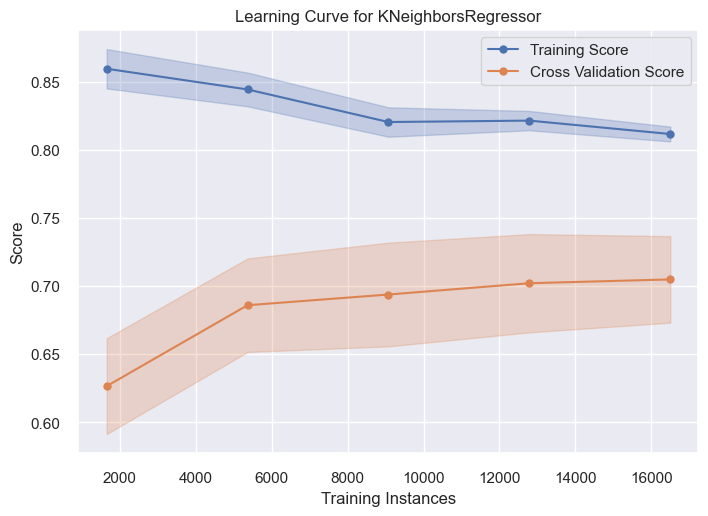

In [144]:
visualizer_knn = LearningCurve(best_knn, scoring='r2', cv=5)
visualizer_knn.fit(X_train, y_train_clipped)
visualizer_knn.score(X_test, y_test)
visualizer_knn.show(clear_figure=True);

In [141]:
help(LearningCurve)

Help on class LearningCurve in module yellowbrick.model_selection.learning_curve:

class LearningCurve(yellowbrick.base.ModelVisualizer)
 |  LearningCurve(estimator, ax=None, groups=None, train_sizes=array([0.1  , 0.325, 0.55 , 0.775, 1.   ]), cv=None, scoring=None, exploit_incremental_learning=False, n_jobs=1, pre_dispatch='all', shuffle=False, random_state=None, **kwargs)
 |  
 |  Visualizes the learning curve for both test and training data for
 |  different training set sizes. These curves can act as a proxy to
 |  demonstrate the implied learning rate with experience (e.g. how much data
 |  is required to make an adequate model). They also demonstrate if the model
 |  is more sensitive to error due to bias vs. error due to variance and can
 |  be used to quickly check if a model is overfitting.
 |  
 |  The visualizer evaluates cross-validated training and test scores for
 |  different training set sizes. These curves are plotted so that the x-axis
 |  is the training set size and